In [2]:
import os
os.chdir('/mnt/zfsusers/hollowayp/paltas/')
import sys
sys.path.append('/mnt/zfsusers/hollowayp/paltas/')
import paltas
from paltas.Analysis import hierarchical_inference
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import emcee
import corner
import numba
import os

np.random.seed(4)

2023-11-02 17:32:53.802919: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 17:32:53.847554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 17:32:53.847594: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 17:32:53.847622: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 17:32:53.856531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 17:32:53.857591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Running Hierarchical Inference on a Population of Strong Lenses

__Author:__ Sebastian Wagner-Carena

__Goals: Understand how to run hierarchical inference on the network outputs using `paltas`__ 

__If you have not already done so, you will have to install `tensorflow` to run the Analysis module tools in this notebook. This notebook will also take advantage of the package `emcee`, although you you can use any sampler you like. For the plotting we will use `corner`.__

## Making our data

To best illustrate how the hierarchical inference tools work, we'll generate a set of artificial network outputs. However, the pipeline outlined here will work equally well with true network outputs. To do this we need to simulate a) the prior we use for trianing and b) the information content of the image. We will focus only on the SHMF normalization and therefore assume that the information content of the image is very low compared to the prior.



In [3]:
# Define the true population mean and its scatter
true_mean = 1e-3
true_scatter = 3e-4

# Assume some consistent, large noise for all of our lens images
image_information_scatter = np.random.uniform(low=4e-3,high=6e-3,size=100)
image_mean = true_mean + np.random.normal(size=100)*image_information_scatter + np.random.normal(size=100)*true_scatter

# This in the mean and scatter of the information in each image, but remember our network predicts a posterior which means we need to multiply our likelihood
# by the training prior
train_mean = 2e-3
train_scatter = 1e-3
network_means = (image_mean * train_scatter**2 + train_mean*image_information_scatter**2)/(train_scatter**2 + image_information_scatter**2)
network_scatter = np.sqrt((train_scatter**2 * image_information_scatter**2)/(train_scatter**2 + image_information_scatter**2))

Now we have the image information and the network outputs. The network outputs are dominated by the prior. Quickly, let's confirm that a) if we combined the image information we would get a likelihood consistent with with the true mean and b) if we combine the network outputs we would get a likelihood consistent with the training mean.

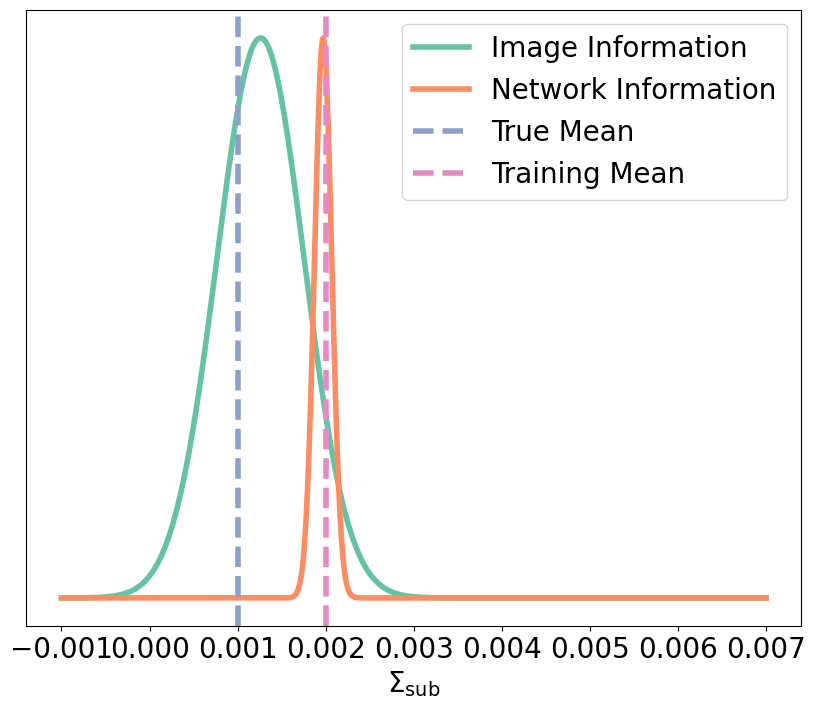

In [4]:
# Start by combining all the image level information
plt.figure(figsize=(10,8))
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
x = np.linspace(-1e-3,7e-3,1000)
prod = np.zeros(len(x))
for i in range(100):
    prod += norm(loc = image_mean[i],scale=image_information_scatter[i]).logpdf(x)
# Normalize the max to 1 for visualization
prod -= np.max(prod)
plt.plot(x,np.exp(prod),label='Image Information',c=colors[0],lw=4)

# Now combine the network outputs
prod = np.zeros(len(x))
for i in range(100):
    prod += norm(loc = network_means[i],scale=network_scatter[i]).logpdf(x)
prod -= np.max(prod)
plt.plot(x,np.exp(prod),label='Network Information',c=colors[1],lw=4)
plt.axvline(true_mean,label='True Mean',c=colors[2],lw=4,ls='--')
plt.axvline(train_mean,label='Training Mean',c=colors[3],lw=4,ls='--')
plt.legend(fontsize=20)
plt.xlabel(r'$\Sigma_\mathrm{sub}$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([])
plt.show()

Note because there is scatter in our true values, the combination we did above is not statistically correct, but it gives us a good idea of the challenges we face. The information about the population mean exists in the sample, but it washed out by the prior in the posteriors our network is estimating.

## Hierarchical Inference

Now we can use our hierarchical inference tools to combine the network outputs and attempt to infer the population mean and scatter of the SHMF normalization.

All of the work gets done by `hierarchical_inference.ProbabilityClassAnalytical` and `emcee`. `ProbabilityClassAnalytical` needs to be initialized with the mean vector and covariance matrix defining the interim training distribution (this class assumed that every distribution being considered is a multivariate Gaussian, but there are other classes in `hierarchical_inference.py` that relax that assumption at the cost of computational time).

In [6]:
# Let's define a few of the parameters for our inference
n_lenses = 100
n_emcee_samps = int(1e4)
burnin = int(1e3)
chains_folder = 'notebook_data/'
backend_path = 'example_chains.h5'
chains_path = os.path.join(chains_folder,backend_path)

# Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
# expect an array of mean values and a precision matrix.
y_pred = network_means[:n_lenses].reshape((n_lenses,1))
prec_pred = 1/np.square(network_scatter[:n_lenses].reshape((n_lenses,1,1)))

# The interim training distribution.
mu_omega_i = np.array([train_mean])
cov_omega_i =np.diag(np.array([train_scatter])**2)

# We will want to initialize emcee near the correct values.
mu_omega = np.array([true_mean])
cov_omega =np.diag(np.array([true_scatter])**2)
true_hyperparameters = np.concatenate([mu_omega,np.log(np.diag(np.sqrt(cov_omega)))])

# A prior function that mainly just bounds the uncertainty estimation.
@numba.njit()
def eval_func_omega(hyperparameters):
    # Enforce that the SHMF normalization is not negative
    if hyperparameters[0] < 0:
        return -np.inf
    # Need to set bounds to avoid random singular matrix proposals
    if hyperparameters[1] < -12:
        return -np.inf
    return 0

# Initialize our class and then give it the network predictions. These are set to global variables in case you want to use
# pooling.
prob_class = hierarchical_inference.ProbabilityClassAnalytical(mu_omega_i,cov_omega_i,eval_func_omega)
prob_class.set_predictions(mu_pred_array_input=y_pred,prec_pred_array_input=prec_pred)

# Set a few of the parameters we will need to pass to emcee
n_walkers = 40
ndim = 2

# Generate an initial state around the true values (this helps with convergence for this example) 
initial_std = np.array([5e-4,1])
cur_state = (np.random.rand(n_walkers, ndim)*2-1)*initial_std
cur_state += true_hyperparameters

#backend = emcee.backends.HDFBackend(chains_path)
sampler = emcee.EnsembleSampler(n_walkers, ndim,prob_class.log_post_omega)#,backend=backend)
sampler.run_mcmc(cur_state,n_emcee_samps,progress=True)
chain = sampler.chain[:,burnin:,:].reshape((-1,2))

HYP [ 7.32374302e-04 -7.42489087e+00]


Let's visualize the constraints using `corner`

In [ ]:
corner_param_print=[r'$\Sigma_\mathrm{sub,pop} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$',
                    r'$\log \Sigma_\mathrm{sub,pop,\sigma} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$']
fontsize = 20
color='#FFAA00'
truth_color = 'k'
hist_kwargs = {'density':True,'color':color,'lw':3}

corner.corner(chain,labels=corner_param_print,bins=20,show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
              levels=[0.68,0.95],color=color,fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',truths=true_hyperparameters,
              truth_color=truth_color,max_n_ticks=3)
plt.show()

You have an unbiased inference of the mean, and it's clear from this data that the constrain on the scatter is an upper limit (not suprising given the small scatter and the large uncertainty of the information we assigned to each data point). 